# Simple Linear Regression using `tensorflow`

Now that we've coded up our simple linear regression solution by building a computational graph with `theano`, we'll do the same with `tensorflow`. Once we build this computational graph, we'll take advantage of the automatic differentiation that `tensorflow` offers. 

## Computational Graphs for Simple Linear Regression 

As a reference, the computational graphs that we used to visualize the forward and backward propagation steps in solving our simple linear regression problem with gradient descent are as follows: 

### Forward Propagation 

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/simp_linear_comp_graph_forprop.png?raw=true" width=400\>

### Backward Propagation 

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/simp_linear_comp_graph_backprop.png?raw=True" width=400\>

### Building a computational graph with `tensorflow`

In the same manner as we coded up our computational graph using `theano`, let's look at how to code this up one piece at a time with `tensorflow`, discussing along the way how it works.

In [1]:
import numpy as np
import tensorflow as tf
from datasets.general import gen_simple_linear
from utils.plotting import plot_errors
%matplotlib inline

In [2]:
def get_tensorflow_graph(): 
    learning_rate = 0.1
    # 1. Define placeholder matrices for inputs.
    xs = tf.placeholder(tf.float32, name='xs') 
    ys = tf.placeholder(tf.float32, name='ys')
    # 2. Define randomly initialized floats for beta_0 and beta_1. 
    beta_0 = tf.Variable(np.random.random(), name='beta_0')
    beta_1 = tf.Variable(np.random.random(), name='beta_1')

    # 3. Define the equation that generates predictions.
    yhats = beta_0 + xs * beta_1
    # 4. Define the equation that generates our errors. 
    es = 0.5 * (ys - yhats) ** 2
    # 5. Define the aggregate cost (mean of squared errors)
    E = tf.reduce_mean(es)
    # 6. Take advantage of `tensorflows` automatic differentiation. 
    d_beta_0, d_beta_1 = tf.gradients(E, [beta_0, beta_1])

    # 7. Perform the update step, and use `assign` to actually update the value. 
    new_beta_0 = beta_0 - learning_rate * tf.reduce_mean(d_beta_0)
    new_beta_1 = beta_1 - learning_rate * tf.reduce_mean(d_beta_1)
    beta_0_update = tf.assign(beta_0, new_beta_0)
    beta_1_update = tf.assign(beta_1, new_beta_1)
    
    # Unfortunately, to have this working as a function, we have to return all of these 
    # individual pieces. 
    return E, beta_0, beta_1, beta_0_update, beta_1_update, xs, ys

From a high level, `get_tensorflow_graph` returns back the steps necessary to perform one iteration of our gradient descent procedure. It's a little different from `get_theano_graph` ([notebook 1c](https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/01-simple-linear/1c_nn_th.ipynb)), though, in that it returns back individual pieces rather than a callable function. In general, the steps still more or less line up - steps `1-5` define the **forward pass**, step `6` defines the **backward pass**, and step `7` sets us up to be able to perform an iteration of the gradient descent procedure and update our coefficients accordingly.

Let's walk through each of the individual pieces being returned...

1. The mean squared error (`E`) is returned so that we can track it through each iteration. 

2. `beta_0` and `beta_1` are returned so that we can reference them below to initialize them (see the `tf.intialize_variables` call; we could also use `tf.initialize_all_variables`). Note that both `beta_0` and `beta_1` are initialized as [Variable objects](https://www.tensorflow.org/versions/r0.9/get_started/basic_usage.html#variables), which is what allows their values to be shared and updated across iterations.  

3. `beta_0_update` and `beta_1_update` hold the computational graph that will be run in order to perform an iteration of the gradient descent procedure. When run in a session below, any steps that are necessary to perform the coefficient update specified by `beta_0_update` and `beta_1_update` will be run, which in effect is every step that is part of the forward and backward propagation. The [use of assign](https://www.tensorflow.org/versions/r0.9/api_docs/python/state_ops.html#Variable) in step `7` is what allows us to actually update the values for `beta_0` and `beta_1`, whereas `beta_0_update` and `beta_1_update` are what we use to refer to these updates and later tell `tensorflow` to perform them.   

4. Finally, `xs` and `ys` are placeholders for our data, and are returned so that we can tell `tensorflow` exactly what part of the graph our real data should line up with. 

Now, let's write the code that runs a `tensorflow` session to learn the values for our coefficients. 

Final Error: 1.4546701343487456e-10


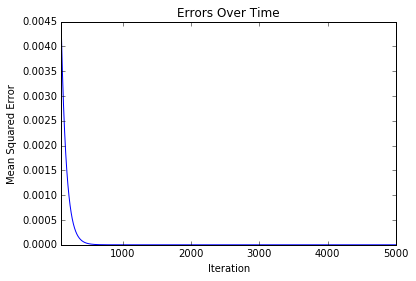

In [3]:
# Randomly generate a beta_0, beta_1, and number of observations, used to generate 
# fake data to fit. We need a minimum of 2 obs. 
true_beta_0, true_beta_1 = np.random.randint(2, 10, size=2) 
n_obs = np.random.randint(9500, 10500)

# Generate the tensorflow graph. This is in a function so that we can run this cell multiple 
# times and obtain different randomly generated values for `beta_0` and `beta_1`. 
E, beta_0, beta_1, beta_0_update, beta_1_update, xs, ys = get_tensorflow_graph()

# Generate the data that follows a linear relationship specified 
# by true_beta_0 and true_beta_1.
x, y = gen_simple_linear(true_beta_0, true_beta_1, n_obs)

# Define the initialization operation. 
init = tf.initialize_variables([beta_0, beta_1])
with tf.Session() as sess: 
    sess.run(init) # Perform the actual initialization operation. 
 
    # Perform iterations (forward & backward prop.) over the tensorflow graph
    mean_squared_errors = []
    for step in range(5000):
        mean_squared_error, beta_0, beta_1 = sess.run([E, beta_0_update, beta_1_update], 
                                                       feed_dict={xs : x, ys : y}) 
        mean_squared_errors.append(mean_squared_error)
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(mean_squared_errors, iterations=(100, 5000))
print("Final Error: {}".format(mean_squared_errors[-1]))

In comparing our `tensorflow` implementation to either our `numpy` or `theano` implementation, the biggest difference we can see is that our `tensorflow` implementation is run via a `Session` object. A [Session object](https://www.tensorflow.org/versions/r0.9/api_docs/python/client.html#session-management) allows us to encapsulate all of the calculations and implementation details of our graph (or any  graph) into a single environment. This turns out to be  useful when we want to run multiple graphs, each of which might have their own specialized environment.  

After creating the `Session` object, our first step is to [initialize any variables](https://www.tensorflow.org/versions/r0.9/how_tos/variables/index.html#initialization) that will be used in the graph. For us, this is just `beta_0` and `beta_1`. Once we have created a `Session` object and initialized all of our variables, we can run pieces of our graph or ask for the values of variables by passing them into `Session.run`. For example, any time that we want to view the values for `beta_0` and `beta_1`, we run: 

```
Session.run([beta_0, beta_1])
``` 

If we run this **before** any iterations of gradient descent, then we'll simply get back the initial values that were given to `beta_0` and `beta_1`. If we want to run one iteration of our gradient descent procedure, we run the following: 

```
Session.run([beta_0_update, beta_1_update], feed_dict={xs : x, ys : y})
```

When this piece (or any piece) of the computational graph is passed into `Session.run`, any steps necessary to compute what is asked for will be run. For `beta_0_update` and `beta_1_update`, this is every step in the graph, including the forward propagation (steps `1-5`), the backward propagation (step `6`), and the update itself (`7`). Note that `xs` and `ys` are needed here, and we pass these in via the `feed_dict` argument. For the `feed_dict` argument, the keys are the variables referring to the placeholder objects in the graph, and the values are the data that will be used for those placeholders. After `beta_0_update` and `beta_1_update` are passed through `Session.run`, the values for `beta_0` and `beta_1` will no longer correspond to the values they were initialized with. Note that in the code above that we also ask for `E` back, which is what allows us to track our mean squared error through each iteration. 

Finally, if we run `beta_0_update` and `beta_1_update` in a loop (as we do), we see that we can solve our simple linear regression using this graph built in `tensorflow`.  

Now, we'll move on to coding this up with `keras`. 